<a href="https://colab.research.google.com/github/RewinaB/Deep-Learning-Projects/blob/main/Employee_retention_analysis_and_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import kagglehub
giripujar_hr_analytics_path = kagglehub.dataset_download('giripujar/hr-analytics')

print('Data source import complete.')


Data source import complete.


In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import ShuffleSplit,GridSearchCV,train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hr-analytics/.nfs000000002abd08ff000001ce
/kaggle/input/hr-analytics/HR_comma_sep.csv


In [6]:
df=pd.read_csv('/kaggle/input/hr-analytics/HR_comma_sep.csv', encoding = 'utf-8')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [7]:
df.shape

(14999, 10)

In [8]:
sal={
    'high':3,
    'medium':2,
    'low':1
}

df['num_salary']=df.salary.apply(lambda x: sal[x])

Moving target feature 'left' to last and lowercasing column name for easiness

In [9]:
cols=df.columns.tolist()
cols.insert(len(cols),cols.pop(cols.index('left')))
df=df[cols]
df.columns=[x.lower() for x in cols]

In [10]:
df.head(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,department,salary,num_salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1,1
1,0.80,0.86,5,262,6,0,0,sales,medium,2,1


In [11]:
df.dtypes

,0
satisfaction_level,float64
last_evaluation,float64
number_project,int64
average_montly_hours,int64
time_spend_company,int64
work_accident,int64
promotion_last_5years,int64
department,object
salary,object
num_salary,int64


In [12]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,num_salary,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,1.594706,0.238083
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,0.637183,0.425924
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,1.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,1.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,2.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,2.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,3.000000,1.000000


## Cleaning of data

In [13]:
df.isnull().sum()

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
work_accident,0
promotion_last_5years,0
department,0
salary,0
num_salary,0


NO missing values we can proceed

checking for duplicates

In [14]:
print('no of duplicates: ',len(df[df.duplicated()]))
df.drop_duplicates(inplace=True)

no of duplicates:  3008


/tmp/ipython-input-14-255357578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


## DATA VISUALISATION AND ANALYSIS

Analysis of catogorical features

In [17]:
df.drop(['department', 'salary'], axis=1).groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,num_salary
left,,,,,,,,
0,0.667365,0.715667,3.786800,198.94270,3.262000,0.174500,0.019500,1.637600
1,0.440271,0.721783,3.883476,208.16223,3.881467,0.052737,0.004018,1.434455


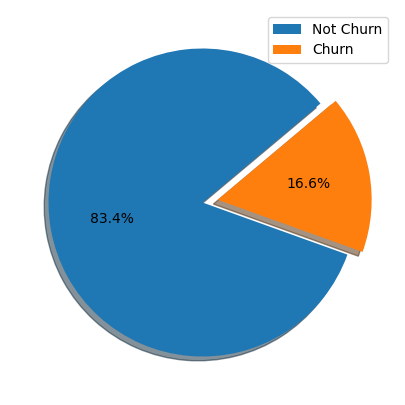

In [16]:
plt.figure(figsize=(6,5))
plt.pie(df.left.value_counts(),explode=[0,0.1],startangle=40,autopct='%1.1f%%',shadow=True)
plt.legend(labels=['Not Churn','Churn'],loc='upper right')
plt.show()

No of employees noleft and left are no in same number it is a imbalanced dataset

####  SALARY

<Axes: xlabel='salary', ylabel='count'>

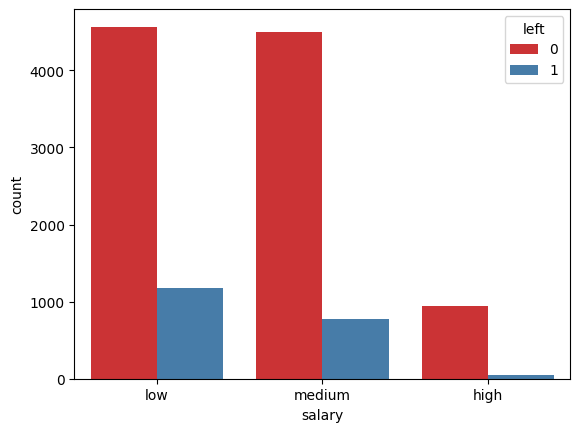

In [18]:
sns.countplot(x='salary',hue='left',palette='Set1',data=df)

####  DEPARTMENT

In [ ]:
plt.figure(figsize=(6,5))
d=df.department.value_counts()
plt.pie(d.values,labels=d.index,autopct='%1.1f%%',shadow=True)
plt.show()

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(x='department',hue='left',palette='twilight_r',data=df)

Sales department has highest no of employees and management has lowest no

In [ ]:
plt.figure(figsize=(12,4))
sns.barplot(x='department',y='satisfaction_level',hue='left',data=df,ci=None)
plt.title('satisfation vs department')
plt.show()

Observations:

. max no of employees is in sales department

. management department has least no of employees

. no observable relationship b/w department and employee churn

. employees with satisfaction-level less than 0.44 in all the department left the company

Lets analyse using heatmap

In [ ]:
plt.figure(figsize=(10,7))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(),annot=True,mask=mask)

Observations:
  1. there are no strong *multicollinearity* b/w any features  
  2. There is no strong correlation b/w any feature and target(left)

In [ ]:
df.corr().left.sort_values()[:-1].plot.barh()

satisfactory level has highest  -ve correlation value with target variable

We shall examine the effect of all factors individually

In [ ]:
sns.histplot(data=df,x='satisfaction_level',hue='left')

In [ ]:
sns.kdeplot(data=df,x='satisfaction_level',y='last_evaluation',hue='left',shade=True)

employees who left company can be distributed into 3 category
  1. hardworking and unhappy
  2. hardworking and happy
  3. not hardworking and not that happy

 Promotion

In [ ]:
pd.crosstab(df.promotion_last_5years,df.left).plot(kind='bar')

In [ ]:
df[df.left==1].promotion_last_5years.value_counts(sort=False)

almost all the employee left did not get promotion

but we can also see that getting promotion in this company is also a rare case

4.average_montly_hours

In [ ]:
sns.kdeplot(data=df,x='average_montly_hours',hue='left',shade=True)

almost all the employees who worked for more than 290 hours left this company

In [ ]:
sns.countplot(x='number_project',data=df,hue='left',palette='prism')

In [ ]:
df[df.number_project==7].describe(percentiles=[])

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(x='salary',hue='left',palette='copper',data=df[df.number_project==7])

for employees who worked on 7 projects there is no promotion and salary of most of them is also
less they are also have more work hour these employees are hardworking but without proper returns
hence they are leaving this company

we can also see employees worked only on 2 projects are also more likely to leave

 time_spend_company

In [ ]:
sns.countplot(x='time_spend_company',hue='left',palette='plasma',data=df)

 * employees who worked in comapany for more than 6 years shows least tendency to leave the company
 * company have majority of people with 3Years of experience and at 3rd year most employees tend to leave

In [ ]:
df1=df[df.left==1].copy()
kmeans = KMeans(n_clusters=3,random_state=2)
df1['kmean_label']=kmeans.fit_predict(df1[["satisfaction_level","last_evaluation"]])

fig = plt.figure(figsize=(10, 6))
sns.scatterplot(x='satisfaction_level',y='last_evaluation',data=df1,
                hue='kmean_label',palette=['g','r','b'],alpha=0.8)
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],
            color="black",marker="X",s=100)
plt.xlabel("satisfaction")
plt.ylabel("Evaluation")
plt.title("Clusters of Employee churn")
plt.show()

In [ ]:
df1.groupby('kmean_label').mean()

### ANALYSIS REPORT

We can broadly classify churn employees into 3 categories


* Cluster 0 >> hardworking and not_satisfied:
        1. more work hour (271)
        2. more experience (avg 6 projects , 4 year)
    + churn reason:
        1. low salary they expect higher salary as they work for more hours
        2. very low promotion rate
  
  
* Cluster 1 >> hardworking and satisfied:
        1. more work hour (249)
        2. more experience (avg 4 projects , 5 year)
    + churn reason:
        1. lower salary
        2. very low promotion rate
        3. as they have higher experience  they can find other company which offer more salary easily
   
   
* Cluster 2 >> not hardworking and not that saisfied:
        1. medium work hour (149)
        2. less experience (avg 2 projects , 3 year)
    + churn reason:
        1. lesser experience and less interest in their job
        
        
company should concern about first 2 cluster (0,1) employees since they are more productive people
they may be retained by giving higher salary and promotions

but its wierd to see mean value of promotion is exatly in opposite order than what we expect

## DATA PREPROCESSING

dropping unnessesary column

In [19]:
processed_df=df.drop(['left','work_accident','department','salary'],axis=1)
processed_df.sample(4)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,promotion_last_5years,num_salary
9301,0.59,0.51,3,156,3,0,2
1587,0.09,0.96,6,281,4,0,2
2221,0.78,0.81,4,232,3,0,2
1806,0.45,0.57,2,143,3,0,1


## Model Building

In [20]:
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)

In [21]:
df.left.value_counts()

,count
left,
0,10000
1,1991


since this dataset is imbalenced i will use smote to generate additon datapoints to balance dataset

In [22]:
smote=SMOTE(sampling_strategy="minority")
X,y=smote.fit_resample(processed_df,df.left)
X.shape , processed_df.shape

((20000, 7), (11991, 7))

Scaling data

In [23]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
models=[RandomForestClassifier(),DecisionTreeClassifier(),GradientBoostingClassifier()
            ,KNeighborsClassifier(n_neighbors=2),LogisticRegression()]

scores=[]
for model in models:
    scores.append(cross_val_score(model,X_scaled,y,n_jobs=-1,cv=cv).mean())
pd.DataFrame(scores,index=models).sort_values(by=0,ascending=False)

,0
RandomForestClassifier(),0.97025
DecisionTreeClassifier(),0.95715
GradientBoostingClassifier(),0.95715
KNeighborsClassifier(n_neighbors=2),0.95530
LogisticRegression(),0.79095


In [25]:
model_params={
    'DecisionTreeClassifier':{
        'model':DecisionTreeClassifier(),
        'params':{
            'criterion':['gini','entropy'],
            'max_features':['auto',"log2"]
        }
    },
    'RandomForestClassifier':{
        'model':RandomForestClassifier(),
        'params':{
            'criterion':['gini','entropy'],
            'max_features':['auto',"log2"]
        }
    }
}

In [26]:
score=[]
for name,model in model_params.items():
    clf=GridSearchCV(model['model'],model['params'],cv=cv,return_train_score=False)
    clf.fit(X,y)
    score.append({
        'model':name,
        'best_score':clf.best_score_,
        'best_params': clf.best_params_
    })
pd.DataFrame(score).sort_values(by='best_score',ascending=False)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

,model,best_score,best_params
1,RandomForestClassifier,0.97165,"{'criterion': 'gini', 'max_features': 'log2'}"
0,DecisionTreeClassifier,0.95460,"{'criterion': 'entropy', 'max_features': 'log2'}"


RandomForest ouperformed other with accuracy_score of 97.2 %  with parameters gini and auto

Logistic Regression performed worst with score 79%

lets analyse RandomForest model in detail

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10,stratify=y)

In [28]:
rfc=RandomForestClassifier(max_features='log2')
rfc.fit(X_train,y_train)
y_predicted=rfc.predict(X_test)
rfc.score(X_test,y_test)

0.96875

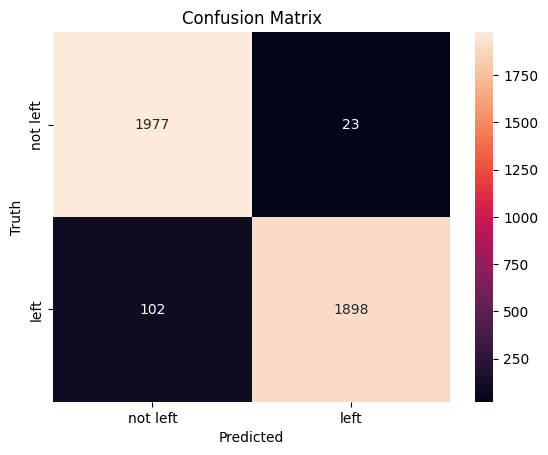

In [29]:
cm=confusion_matrix(y_test,y_predicted)
labels=['not left','left']
plt.title('Confusion Matrix')
sns.heatmap(cm,annot=True,fmt='g',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [30]:
print('           --------RandomForestClassifier--------')

print(classification_report(y_test,y_predicted))

           --------RandomForestClassifier--------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2000
           1       0.99      0.95      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



Nural Networks

In [31]:
model=keras.Sequential([
keras.layers.Dense(20,input_shape=(X_train.shape[1],),activation='relu'),
keras.layers.Dense(15,activation='relu'),
keras.layers.Dense(10,activation='relu'),
keras.layers.Dense(5,activation='relu'),
keras.layers.Dense(1,activation='sigmoid')
])
model.compile(
   optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train,y_train,epochs=20)

print(classification_report(y_test,np.round(model.predict(X_test))))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5098 - loss: 1.7733
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5349 - loss: 0.6902
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6278 - loss: 0.6621
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7242 - loss: 0.5863
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7934 - loss: 0.4924
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8478 - loss: 0.4192
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8757 - loss: 0.3760
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8814 - loss: 0.3444
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8894 - loss: 0.3222
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8954 - loss: 0.3022
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9012 - loss: 0.2925
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

### Conlusion
RandomForestClassifier performed best with accuracy_score of 97.5 %